In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8.error_models import BaseErrorModel, LinearErrorModel
from estim8 import visualization, datatypes, Estimator, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load and init model
SimpleBatchModel = FmuModel(path=r'SimpleBatch.fmu')
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0)

# 07. Federated worker setup

Parameter estimation times depend one a series of factors, e.g. the dimensionality of the estimation problem or the solution landscape. In most cases, the model simulation to evaluate a candidate solution vector $\theta$ is the time-limiting step, which is further stretched with increased numbers of experimental replicates.  To address this issue, `estim8` introduces as setup employing _federated computing_ principles for _differentiable cost functions_, effectively yielding a second parallelization layer for computation tasks.

Essentially, federated Workers are launched as gRPC services bound to a unique _host_ and _port_ network address. Evaluation calls for replicate specific parameter sets in the objective function are then distributed to these workers using [PyTensor](https://github.com/pymc-devs/pytensor) and [pytensor_federated](https://github.com/michaelosthege/pytensor-federated). 

<img src="../docs/source/images/federated_workers.jpg" alt="federated_workers" width="800"/>

Using a federated worker setup, heavy computations can be effectively distributed among machines, exploiting parralel computer architectures like workstations or computer. clusters. 

We start by creating an artificial noisy dataset of 3 replicates like in Notebook `4. Modeling experimental replicates`. 

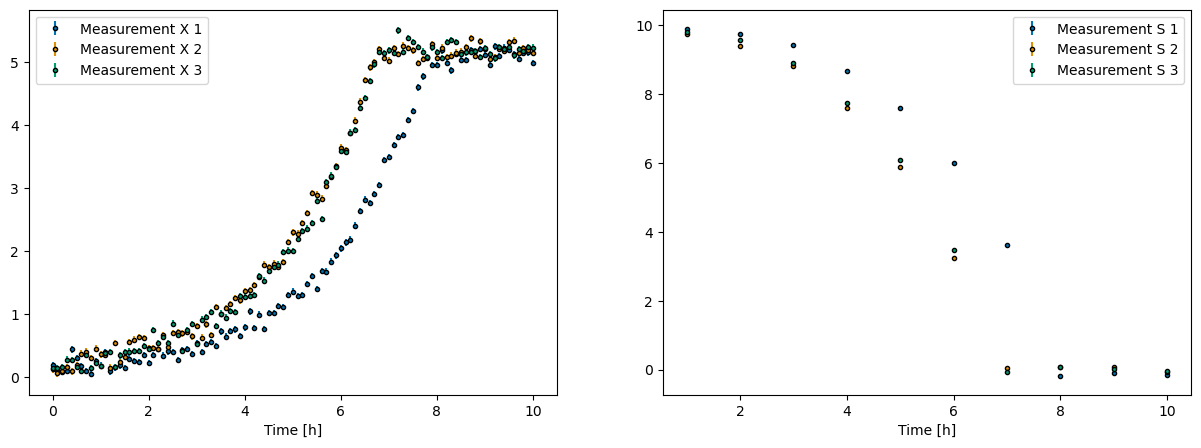

In [2]:
# define number of replicates and IDs
replicate_IDs = [str(i) for i in range(1,4)]

# create a parameter mapping
replicate_specific_parameters = ["X0"]
parameter_mapping = utils.ModelHelpers.ParameterMapping(
    mappings=[utils.ModelHelpers.ParameterMapper(
        global_name = param,
        replicate_ID = r_ID,
        value = 0.1 + np.random.random()/10  # use a random turbulence
    )
    for r_ID in replicate_IDs
    for param in replicate_specific_parameters],
    default_parameters = SimpleBatchModel.parameters,
    replicate_IDs = replicate_IDs
)


# create 2 artificial datasets
def make_experiment(parameters, model: FmuModel, original_data: pd.DataFrame, error_model: BaseErrorModel = LinearErrorModel(), rID: str = datatypes.Constants.single_id, resample=4):
    simulation = model.simulate(t0=0, t_end=10, stepsize=0.1, parameters=parameters)

    measurements = []
    for obs in original_data.columns:
        model_prediction = simulation[obs]
        # get timepoints of measurements from datesheet above
        timepoints = original_data[obs].dropna().index
        values = model_prediction.interpolate(timepoints)
        # get noisy values by resampling the data according to erro models distribution
        for _ in range(resample):
            values = error_model.get_sampling(values, 1)[0]

        measurements.append(
            datatypes.Measurement(
                name = model_prediction.name,
                timepoints=timepoints,
                values=values,
                error_model=error_model,
                replicate_ID=rID
            )
        )
    return datatypes.Experiment(measurements, replicate_ID=rID)


# create noisy data
artificial_data = dict()
for r_ID in replicate_IDs:
    replicate_parameters = parameter_mapping.replicate_handling(
        replicate_ID=r_ID
    )

    artificial_data[r_ID] = make_experiment(parameters=replicate_parameters, original_data=data, model=SimpleBatchModel, error_model=LinearErrorModel(offset=0.05), rID=r_ID)

# plot data
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(15, 5)
)

for (r_ID, experiment), color in zip(artificial_data.items(),sns.color_palette("colorblind") ):
    for ax, measurement in zip(axes, experiment.measurements):
        visualization.plot_measurement(ax=ax, measurement=measurement, color=color, ecolor=color)
        ax.set_xlabel('Time [h]')
        ax.legend()

## 7.1 Federated workers on a single machine
To use this setup on a single local machine, pass the keyword argument `federated_workers`to the `Estimator` class methods.  

### Parameter estimation

Launching 4 workers...
testing workers..
2024-11-06 15:24:37,920 [INFO] Client 1949739579664-15268-624 connected to localhost:9500
2024-11-06 15:24:37,946 [INFO] Closing evaluation stream
2024-11-06 15:24:37,948 [INFO] Client 1949739829568-15268-624 connected to localhost:9501
2024-11-06 15:24:37,970 [INFO] Closing evaluation stream
2024-11-06 15:24:37,972 [INFO] Client 1949739833168-15268-624 connected to localhost:9502
2024-11-06 15:24:37,994 [INFO] Closing evaluation stream
2024-11-06 15:24:37,996 [INFO] Client 1949739840272-15268-624 connected to localhost:9503
2024-11-06 15:24:38,018 [INFO] Closing evaluation stream
Worker test succesfull.
2024-11-06 15:24:38,634 [INFO] Client 1949739996960-15268-624 connected to localhost:9503
2024-11-06 15:24:39,192 [INFO] Client 1949739996240-15268-624 connected to localhost:9500
2024-11-06 15:24:39,846 [INFO] Client 1949739997680-15268-624 connected to localhost:9502
differential_evolution step 1: f(x)= 26869.17550546418
differential_evolution

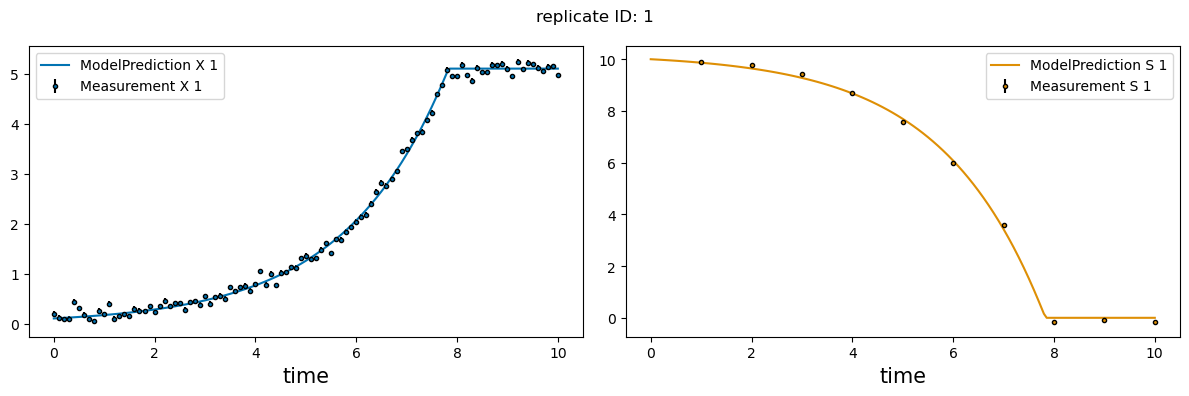

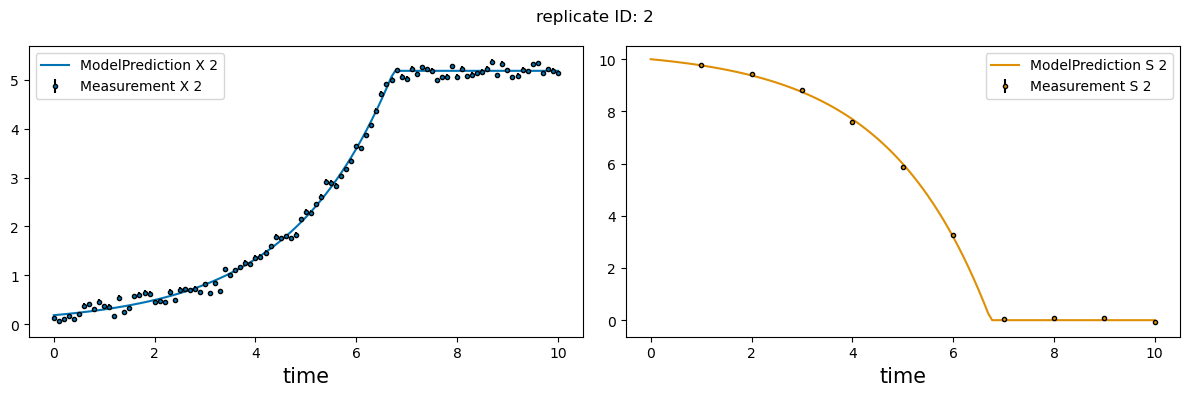

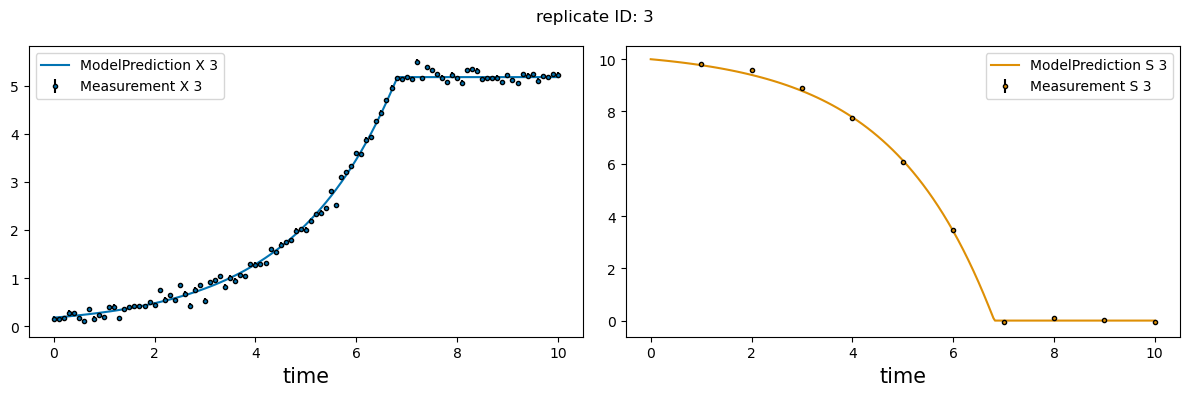

In [3]:
# define unknowns and bounds
bounds = {f"X0_{r_ID}": [0.01, 0.5] for r_ID in replicate_IDs}
bounds["mu_max"] = [0.1, 0.8] 


# instantiate Estimator
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,
    data=artificial_data,
    metric="WSS",
    parameter_mapping=parameter_mapping,
    t=[0, 10, 0.1]
)


estimates, info = estimator.estimate(
    method="de",
    max_iter=1000,
    optimizer_kwargs={"disp": True, "updating": "deferred"},
    n_jobs=1,
    federated_workers=4                                         # use 4 federated workers for parallel simulation
)

_ = visualization.plot_estimates(estimates, estimator, only_measured=True)

### Uncertainty quantification methods
To scale up the procesces, similar to the `estimate` method above, you can define a number of `federated_workers`.

In [4]:
# monte carlo sampling
mc_samples = estimator.mc_sampling(
    method='de',
    max_iter=1000,
    n_jobs=1,
    mcs_at_once=4,
    federated_workers=16,
    n_samples=100
)

Launching 16 workers...
testing workers..
2024-11-06 15:27:27,190 [INFO] Client 1949745292352-15268-624 connected to localhost:9500
2024-11-06 15:27:27,232 [INFO] Closing evaluation stream
2024-11-06 15:27:27,235 [INFO] Client 1949745292352-15268-624 connected to localhost:9501
2024-11-06 15:27:27,260 [INFO] Closing evaluation stream
2024-11-06 15:27:27,263 [INFO] Client 1949745292352-15268-624 connected to localhost:9502
2024-11-06 15:27:27,285 [INFO] Closing evaluation stream
2024-11-06 15:27:27,288 [INFO] Client 1949745292352-15268-624 connected to localhost:9503
2024-11-06 15:27:27,312 [INFO] Closing evaluation stream
2024-11-06 15:27:27,314 [INFO] Client 1949745292352-15268-624 connected to localhost:9504
2024-11-06 15:27:27,337 [INFO] Closing evaluation stream
2024-11-06 15:27:27,339 [INFO] Client 1949745292352-15268-624 connected to localhost:9505
2024-11-06 15:27:27,363 [INFO] Closing evaluation stream
2024-11-06 15:27:27,365 [INFO] Client 1949745292352-15268-624 connected to l

## 7.2 Distributing work among different machines

Employing this federated setup, one can launch workers on one or more machines and just pass the network adresses to the `Estimator`object that runs the optimization task. Assume on both machines the model and data from above are already defined:

### Parameter estimation

In [5]:
# code run on machine A: worker nodes
print(" \n Machine A:")
estimator_A = Estimator(
    model = SimpleBatchModel,
    data=data,
    bounds = {"X0": [0.01, 0.5], "mu_max": [0.2, 0.8]},
    t=[0,10, 0.1]
)

estimator_A.launch_workers(
    host= "localhost",              # use the real host adress of machine A her
    ports=list(range(9500,9506))    # port adresses for workers
)


print("-------------------------------------------------------")


# code run on machine B: parameter estimation
print(" \n Machine B:")
estimator_B = Estimator(
    model = SimpleBatchModel,
    data=data,
    bounds = {"X0": [0.01, 0.5], "mu_max": [0.2, 0.8]},
    t=[0,10, 0.1]
)

hosts_and_ports = [("localhost", port) for port in list(range(9500,9506))]

# set the hosts_and_ports attribute 
estimator_B.hosts_and_ports = hosts_and_ports

estimator_B.estimate(method='de', max_iter=1000, n_jobs=2, federated_workers=True)

 
 Machine A:
Launching 6 workers...


c:\Users\Latour\projects\estim8-s-test\examples\..\estim8\estimator.py:243: UserWarning: n_workers argument overriden by ports.
  warn(f"n_workers argument overriden by ports.")


-------------------------------------------------------
 
 Machine B:
testing workers..
2024-11-06 15:46:14,759 [INFO] Client 1949752452976-15268-624 connected to localhost:9500
2024-11-06 15:46:14,794 [INFO] Closing evaluation stream
2024-11-06 15:46:14,797 [INFO] Client 1949752458448-15268-624 connected to localhost:9501
2024-11-06 15:46:14,819 [INFO] Closing evaluation stream
2024-11-06 15:46:14,822 [INFO] Client 1949757921344-15268-624 connected to localhost:9502
2024-11-06 15:46:14,843 [INFO] Closing evaluation stream
2024-11-06 15:46:14,846 [INFO] Client 1949757924176-15268-624 connected to localhost:9503
2024-11-06 15:46:14,872 [INFO] Closing evaluation stream
2024-11-06 15:46:14,874 [INFO] Client 1949752452496-15268-624 connected to localhost:9504
2024-11-06 15:46:14,901 [INFO] Closing evaluation stream
2024-11-06 15:46:14,903 [INFO] Client 1949752452832-15268-624 connected to localhost:9505
2024-11-06 15:46:14,927 [INFO] Closing evaluation stream
Worker test succesfull.


c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


2024-11-06 15:46:26,565 [WARNING] Lost connection to localhost:9500.
2024-11-06 15:46:26,566 [WARNING] Lost connection to localhost:9503.
2024-11-06 15:46:26,567 [WARNING] Lost connection to localhost:9502.
2024-11-06 15:46:27,442 [INFO] Client 1949739997680-15268-624 connected to localhost:9500
2024-11-06 15:46:27,938 [INFO] Client 1949739996960-15268-624 connected to localhost:9501
2024-11-06 15:46:28,453 [INFO] Client 1949739996240-15268-624 connected to localhost:9503


c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimiz

Shutting down workers...


c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimiz

({'X0': 0.10298154858669142, 'mu_max': 0.49542263458041547},
              message: Optimization terminated successfully.
              success: True
                  fun: 3.8587641855787576
                    x: [ 1.030e-01  4.954e-01]
                  nit: 24
                 nfev: 813
           population: [[ 1.030e-01  4.954e-01]
                        [ 1.015e-01  4.971e-01]
                        ...
                        [ 9.591e-02  5.050e-01]
                        [ 9.981e-02  4.991e-01]]
  population_energies: [ 3.859e+00  3.863e+00 ...  3.896e+00  3.875e+00])